# Multi-label text classification using BERT

In [1]:
!nvidia-smi

Thu Jul 11 02:01:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   49C    P8             16W /  160W |     665MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install transformers

## Imports

In [3]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import sys
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
from collections import defaultdict

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AdamW

from defi_textmine_2025.data import load_test_raw_data
from defi_textmine_2025.data import TARGET_COL, INTERIM_DIR, MODELS_DIR, submission_path

BASE_CHECKPOINT = "bert-base-uncased" #"bert-base-multilingual-uncased"
TASK_NAME = "multilabel_tagged_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}
categories_to_check = ['END_DATE', 'GENDER_MALE', 'WEIGHS', 'DIED_IN', 'HAS_FAMILY_RELATIONSHIP', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'HAS_CATEGORY', 'HAS_CONTROL_OVER', 'IS_BORN_IN', 'IS_OF_SIZE', 'HAS_LATITUDE', 'IS_PART_OF', 'IS_OF_NATIONALITY', 'IS_COOPERATING_WITH', 'DEATHS_NUMBER', 'HAS_FOR_HEIGHT', 'INITIATED', 'WAS_DISSOLVED_IN', 'HAS_COLOR', 'CREATED', 'IS_LOCATED_IN', 'WAS_CREATED_IN', 'IS_AT_ODDS_WITH', 'HAS_CONSEQUENCE', 'HAS_FOR_LENGTH', 'INJURED_NUMBER', 'START_DATE', 'STARTED_IN', 'GENDER_FEMALE', 'HAS_LONGITUDE', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'IS_BORN_ON', 'HAS_QUANTITY', 'OPERATES_IN', 'IS_REGISTERED_AS']

mlb = MultiLabelBinarizer()
mlb.fit([categories_to_check])
logging.info(f"{mlb.classes_=}")

generated_data_dir_path = os.path.join(INTERIM_DIR, "multilabel_tagged_text_dataset")
assert os.path.exists(generated_data_dir_path)

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_multilabel_tagged_text_dataset")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {train_preprocessed_data_dir_path}

model_dir_path = os.path.join(MODELS_DIR, f"finetuned-{BASE_CHECKPOINT}")
! mkdir -p {model_dir_path}
model_dict_state_path = os.path.join(model_dir_path,"MLTC_model_state.bin")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

[02:01:23|INFO|1966819286.py:42] mlb.classes_=array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)


device(type='cuda')

In [4]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

def process_data(data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([data, pd.DataFrame(mlb.transform(data[TARGET_COL]), columns=mlb.classes_, index=data.index)], axis=1) # .drop([TARGET_COL], axis=1)


def format_relations_str_to_list(labels_as_str: str) -> List[str]:
    return json.loads(
        labels_as_str.replace("{", "[").replace("}", "]").replace("'", '"')
    )


def process_csv_to_csv(in_dir_or_file_path: str, out_dir_path: str) -> None:
    """Convert labels, i.e. list of relations category, into one-hot vectors

    Args:
        in_dir_or_file_path (str): str
        out_dir_path (str): str
    """
    if os.path.isdir(in_dir_or_file_path):
        all_files = glob.glob(os.path.join(in_dir_or_file_path , "*.csv"))  
    else:
        assert in_dir_or_file_path.endswith(".csv")
        all_files = [in_dir_or_file_path]
    for filename in (pb:=tqdm(all_files)):
        pb.set_description(filename)
        preprocessed_data_filename = os.path.join(out_dir_path, os.path.basename(filename))
        process_data(load_csv(filename).assign(**{TARGET_COL: lambda df: df[TARGET_COL].apply(format_relations_str_to_list)})).to_csv(preprocessed_data_filename, sep="\t")

## Preprocess and save data

- load generated data
- convert to dataframe
- convert categories into one-hot labels
- save into a tsv file

In [5]:
process_csv_to_csv(os.path.join(generated_data_dir_path, "train"), labeled_preprocessed_data_dir_path)

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/51437.csv:   0%|          | 0/800 [00:00<?, ?it/s]

data/defi-text-mine-2025/interim/multilabel_tagged_text_dataset/train/41884.csv: 100%|██████████| 800/800 [00:02<00:00, 346.99it/s]


## Load preprocessed data

In [6]:
labeled_df = load_csv(labeled_preprocessed_data_dir_path, index_col=0, sep='\t')

## Train-Validation split

- split such that each category exist at least in the train dataset

In [7]:
mlb.classes_

array(['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE',
       'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE',
       'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT',
       'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE',
       'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH',
       'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON',
       'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY',
       'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN',
       'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN',
       'WAS_DISSOLVED_IN', 'WEIGHS'], dtype=object)

In [8]:
labeled_df[mlb.classes_].sum(axis=0).sort_values()

HAS_LATITUDE                 10
HAS_LONGITUDE                12
HAS_FOR_HEIGHT               12
WAS_DISSOLVED_IN             14
HAS_FOR_WIDTH                14
WAS_CREATED_IN               15
HAS_FOR_LENGTH               16
IS_BORN_ON                   20
IS_REGISTERED_AS             34
WEIGHS                       41
DIED_IN                      41
IS_BORN_IN                   50
IS_DEAD_ON                   68
INJURED_NUMBER               70
DEATHS_NUMBER                75
HAS_COLOR                    91
CREATED                     126
IS_OF_NATIONALITY           179
HAS_QUANTITY                191
HAS_FAMILY_RELATIONSHIP     222
RESIDES_IN                  222
IS_COOPERATING_WITH         372
GENDER_FEMALE               414
IS_OF_SIZE                  438
INITIATED                   469
HAS_CONSEQUENCE             769
END_DATE                    874
HAS_CATEGORY                894
GENDER_MALE                 908
START_DATE                 1034
IS_PART_OF                 1462
IS_AT_OD

In [9]:
labeled_df.query("HAS_FOR_HEIGHT==1")[mlb.classes_].sum(axis=0)

CREATED                     0
DEATHS_NUMBER               0
DIED_IN                     0
END_DATE                    0
GENDER_FEMALE               0
GENDER_MALE                 0
HAS_CATEGORY                0
HAS_COLOR                   0
HAS_CONSEQUENCE             0
HAS_CONTROL_OVER            0
HAS_FAMILY_RELATIONSHIP     0
HAS_FOR_HEIGHT             12
HAS_FOR_LENGTH              0
HAS_FOR_WIDTH               0
HAS_LATITUDE                0
HAS_LONGITUDE               0
HAS_QUANTITY                0
INITIATED                   0
INJURED_NUMBER              0
IS_AT_ODDS_WITH             0
IS_BORN_IN                  0
IS_BORN_ON                  0
IS_COOPERATING_WITH         0
IS_DEAD_ON                  0
IS_IN_CONTACT_WITH          0
IS_LOCATED_IN               0
IS_OF_NATIONALITY           0
IS_OF_SIZE                  0
IS_PART_OF                  0
IS_REGISTERED_AS            0
OPERATES_IN                 0
RESIDES_IN                  0
STARTED_IN                  0
START_DATE

In [10]:
df_train, df_valid = train_test_split(labeled_df, test_size = 0.2, shuffle=True, random_state=0)

In [11]:
df_train[mlb.classes_].sum(axis=0).sort_values()

HAS_LATITUDE                  7
HAS_LONGITUDE                11
HAS_FOR_HEIGHT               12
WAS_CREATED_IN               13
WAS_DISSOLVED_IN             13
HAS_FOR_WIDTH                13
HAS_FOR_LENGTH               14
IS_BORN_ON                   17
IS_REGISTERED_AS             27
WEIGHS                       36
DIED_IN                      36
IS_BORN_IN                   40
INJURED_NUMBER               52
IS_DEAD_ON                   53
DEATHS_NUMBER                60
HAS_COLOR                    72
CREATED                      98
HAS_QUANTITY                147
IS_OF_NATIONALITY           149
RESIDES_IN                  176
HAS_FAMILY_RELATIONSHIP     176
IS_COOPERATING_WITH         297
GENDER_FEMALE               318
IS_OF_SIZE                  357
INITIATED                   386
HAS_CONSEQUENCE             613
END_DATE                    686
GENDER_MALE                 718
HAS_CATEGORY                734
START_DATE                  816
IS_PART_OF                 1174
IS_AT_OD

In [12]:
df_valid[mlb.classes_].sum(axis=0).sort_values()

HAS_FOR_HEIGHT                0
WAS_DISSOLVED_IN              1
HAS_LONGITUDE                 1
HAS_FOR_WIDTH                 1
WAS_CREATED_IN                2
HAS_FOR_LENGTH                2
IS_BORN_ON                    3
HAS_LATITUDE                  3
WEIGHS                        5
DIED_IN                       5
IS_REGISTERED_AS              7
IS_BORN_IN                   10
DEATHS_NUMBER                15
IS_DEAD_ON                   15
INJURED_NUMBER               18
HAS_COLOR                    19
CREATED                      28
IS_OF_NATIONALITY            30
HAS_QUANTITY                 44
RESIDES_IN                   46
HAS_FAMILY_RELATIONSHIP      46
IS_COOPERATING_WITH          75
IS_OF_SIZE                   81
INITIATED                    83
GENDER_FEMALE                96
HAS_CONSEQUENCE             156
HAS_CATEGORY                160
END_DATE                    188
GENDER_MALE                 190
START_DATE                  218
IS_AT_ODDS_WITH             283
IS_PART_

## Create the tokenized datasets for model input

In [13]:
# Hyperparameters
MAX_LEN = 256  # TODO: increase
tokenizer = BertTokenizer.from_pretrained(BASE_CHECKPOINT)
# task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [
#     f"<{entity_class}>" for entity_class in entity_classes
# ]
# # add special tokens to the tokenizer
# num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
# num_added_tokens

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
# Test the tokenizer
test_text = "La <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> tchèque a <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>mis la main</e2> sur le couple responsable d'un trafic d'œuvres d'art. Il s'agit de <e1><TERRORIST_OR_CRIMINAL>Patel</e1> et Mirna Maroski. Une <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>perquisition</e2> à leur domicile a permis de retrouver une centaine de tableaux d'artistes européens. Il y avait également des pots en céramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. Les époux Maroski ont été conduits au poste de <e2><NON_MILITARY_GOVERNMENT_ORGANISATION>police</e2> dans un véhicule blindé. Mirna Maroski s'est évanouie une fois arrivée au poste. Elle a été amenée en ambulance au CHU de Motol où elle a été soignée. Monsieur Sergueï Alekseï, le directeur de l'hôpital, a demandé à ses collaborateurs d'être vigilants et de ne pas se laisser corrompre par la criminelle."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = MAX_LEN,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2474,  1026,  1041,  2475,  1028,  1026,  2512,  1035,  2510,
          1035,  2231,  1035,  5502,  1028,  2610,  1026,  1013,  1041,  2475,
          1028, 22975,  5369,  4226,  1037,  1026,  1041,  2475,  1028,  1026,
          2512,  1035,  2510,  1035,  2231,  1035,  5502,  1028, 28616,  2474,
          2364,  1026,  1013,  1041,  2475,  1028,  7505,  3393,  3232, 24501,
         26029, 19150,  1040,  1005,  4895, 19817, 10354,  2594,  1040,  1005,
          1107,  2226, 24790,  1040,  1005,  2396,  1012,  6335,  1055,  1005,
         12943,  4183,  2139,  1026,  1041,  2487,  1028,  1026,  9452,  1035,
          2030,  1035,  4735,  1028, 20455,  1026,  1013,  1041,  2487,  1028,
          3802, 14719,  2532,  9388,  2891,  3211,  1012, 16655,  1026,  1041,
          2475,  1028,  1026,  2512,  1035,  2510,  1035,  2231,  1035,  5502,
          1028,  2566, 15549, 28032,  3258,  1026,  1013,  1041,  2475,  1028,
          1037,  3393,  3126, 14383, 2

In [15]:
tokenizer.batch_decode(encodings['input_ids'])

["[CLS] la < e2 > < non _ military _ government _ organisation > police < / e2 > tcheque a < e2 > < non _ military _ government _ organisation > mis la main < / e2 > sur le couple responsable d'un trafic d'œuvres d'art. il s'agit de < e1 > < terrorist _ or _ criminal > patel < / e1 > et mirna maroski. une < e2 > < non _ military _ government _ organisation > perquisition < / e2 > a leur domicile a permis de retrouver une centaine de tableaux d'artistes europeens. il y avait egalement des pots en ceramique et en porcelaine d'origine chinoise, ainsi que plusieurs faux documents de voyage. les epoux maroski ont ete conduits au poste de < e2 > < non _ military _ government _ organisation > police < / e2 > dans un vehicule blinde. mirna maroski s'est evanouie une fois arrivee au poste. elle a ete amenee en ambulance au [SEP]"]

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        # self.e1 = list(df['e1'])
        # self.e1 = list(df['e1'])
        # self.text_indexes = list(df['text_index'])
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        text = str(self.title[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': text,
            # 'text_index': self.text_index[index],
            # 'e1': self.e1[index],
            # 'e2': self.e2[index],
        }

In [17]:
# most_common_categories = df_train[mlb.classes_].sum().sort_values(ascending=False).index[:7]
# logging.info(most_common_categories)
# # target_list = mlb.classes_.tolist()
# target_list = most_common_categories
target_list = mlb.classes_
logging.info(f"{len(target_list)} categories = {target_list}")

[02:01:27|INFO|1100424365.py:6] 37 categories = ['CREATED' 'DEATHS_NUMBER' 'DIED_IN' 'END_DATE' 'GENDER_FEMALE'
 'GENDER_MALE' 'HAS_CATEGORY' 'HAS_COLOR' 'HAS_CONSEQUENCE'
 'HAS_CONTROL_OVER' 'HAS_FAMILY_RELATIONSHIP' 'HAS_FOR_HEIGHT'
 'HAS_FOR_LENGTH' 'HAS_FOR_WIDTH' 'HAS_LATITUDE' 'HAS_LONGITUDE'
 'HAS_QUANTITY' 'INITIATED' 'INJURED_NUMBER' 'IS_AT_ODDS_WITH'
 'IS_BORN_IN' 'IS_BORN_ON' 'IS_COOPERATING_WITH' 'IS_DEAD_ON'
 'IS_IN_CONTACT_WITH' 'IS_LOCATED_IN' 'IS_OF_NATIONALITY' 'IS_OF_SIZE'
 'IS_PART_OF' 'IS_REGISTERED_AS' 'OPERATES_IN' 'RESIDES_IN' 'STARTED_IN'
 'START_DATE' 'WAS_CREATED_IN' 'WAS_DISSOLVED_IN' 'WEIGHS']


In [18]:
df_train.shape, df_valid.shape

((21115, 42), (5279, 42))

In [19]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)

In [20]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101, 19804,  2229,  3393,  6019,  4241,  5939, 20846, 21864,  1037,
         10958,  3567,  3351, 16655,  2112,  2666,  2139,  2474, 20184,  2139,
          6887,  2319, 16215,  2666,  2102,  1010,  3393,  1000,  1038, 16523,
          2078,  1000,  3802,  1048,  1005,  2006,  2290,  1000,  3745,  8438,
          1000,  2006,  2102,  8902, 20470,  5686, 10364,  4487,  3367,  3089,
          8569,  2121,  4078,  6819, 24790,  3802,  4078,  9311,  2229, 19554,
          8254,  2923,  6072,  1012,  6335,  2015,  2006,  2102,  2033,  4168,
          2128, 17854,  2072,  1037, 20710,  3366, 19661,  2099,  4078, 19960,
          5555,  8163, 10364,  4649,  6778,  2229,  1012, 21380,  1026,  1041,
          2487,  1028,  1026,  6831,  1028, 15775, 27543,  2402,  1026,  1013,
          1041,  2487,  1028,  1010,  3393,  4241,  1000,  1038, 16523,  2078,
          1000,  1010,  1037,  1041,  9692, 13665, 28616,  1037, 22137,  4078,
         10819,  8162, 27870,  2015,  4

## Create data loaders

In [21]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32

# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## Prepare the model to trained

In [22]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained(BASE_CHECKPOINT, return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [23]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [24]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Function to tain the model

In [25]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate dropout, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,37)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

## Function to evaluate the model

In [26]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [27]:
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid

history = defaultdict(list)
best_accuracy = 0
assert not os.path.exists(model_dict_state_path), "The trained model is already serialized at {model_dict_state_path}"

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), model_dict_state_path)
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.2023, val_loss=0.1134 train_acc=0.9521, val_acc=0.9677
Epoch 2/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.1042, val_loss=0.0904 train_acc=0.9699, val_acc=0.9739
Epoch 3/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0851, val_loss=0.0758 train_acc=0.9738, val_acc=0.9746
Epoch 4/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0740, val_loss=0.0679 train_acc=0.9749, val_acc=0.9758
Epoch 5/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0666, val_loss=0.0629 train_acc=0.9766, val_acc=0.9775
Epoch 6/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0612, val_loss=0.0583 train_acc=0.9785, val_acc=0.9791
Epoch 7/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0570, val_loss=0.0545 train_acc=0.9799, val_acc=0.9800
Epoch 8/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0535, val_loss=0.0514 train_acc=0.9808, val_acc=0.9813
Epoch 9/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0500, val_loss=0.0498 train_acc=0.9821, val_acc=0.9819
Epoch 10/10


  0%|          | 0/660 [00:00<?, ?it/s]

train_loss=0.0469, val_loss=0.0473 train_acc=0.9832, val_acc=0.9826


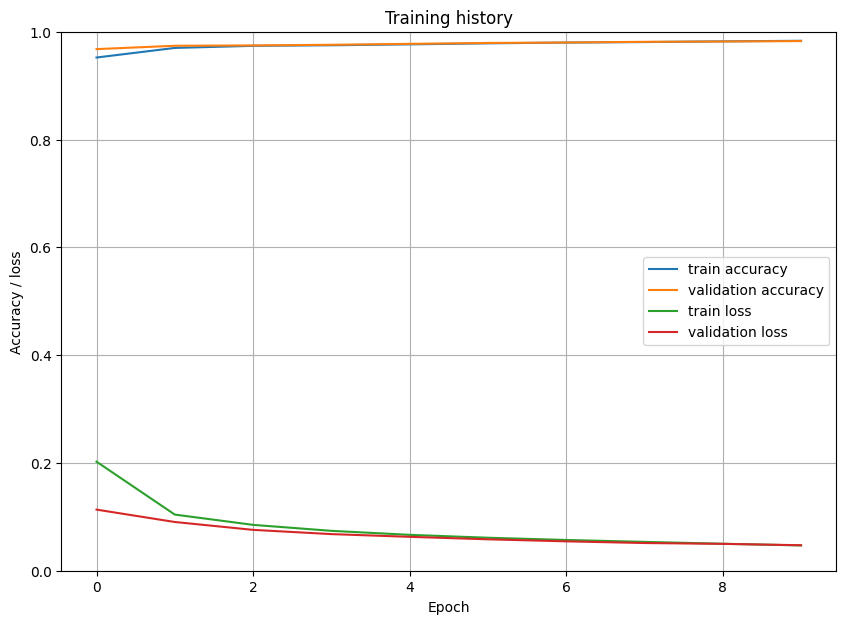

In [28]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Accuracy / loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Evaluation of the model

In [29]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(model_dict_state_path))
model = model.to(device)

In [30]:
# Evaluate the model using the test data
val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

In [31]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
val_acc

0.9826338936018799

In [48]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in tqdm(data_loader):
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values


In [49]:
titles, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

100%|██████████| 165/165 [00:35<00:00,  4.60it/s]


In [52]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list, zero_division=0))

                         precision    recall  f1-score   support

                CREATED       0.00      0.00      0.00        28
          DEATHS_NUMBER       0.00      0.00      0.00        15
                DIED_IN       0.00      0.00      0.00         5
               END_DATE       0.82      0.75      0.79       188
          GENDER_FEMALE       0.00      0.00      0.00        96
            GENDER_MALE       0.66      0.98      0.79       190
           HAS_CATEGORY       0.62      0.37      0.46       160
              HAS_COLOR       0.00      0.00      0.00        19
        HAS_CONSEQUENCE       0.86      0.66      0.75       156
       HAS_CONTROL_OVER       0.78      0.28      0.41       918
HAS_FAMILY_RELATIONSHIP       0.00      0.00      0.00        46
         HAS_FOR_HEIGHT       0.00      0.00      0.00         0
         HAS_FOR_LENGTH       0.00      0.00      0.00         2
          HAS_FOR_WIDTH       0.00      0.00      0.00         1
           HAS_LATITUDE 

In [ ]:
# import seaborn as sns
# def show_confusion_matrix(confusion_matrix):
#     hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
#     hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
#     hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
#     plt.ylabel('True category')
#     plt.xlabel('Predicted category');

In [ ]:
# cm = confusion_matrix(target_values, predictions)
# df_cm = pd.DataFrame(cm, index=target_list, columns=target_list)
# show_confusion_matrix(df_cm)

## Prepare submission

In [32]:
df_test = load_csv(os.path.join(generated_data_dir_path, "test")) #.drop(TARGET_COL, axis=1)
df_test

,text_index,e1,e2,text,relations
0,51344,0,0,Un Un <e1><FIRE>incendie</e1> a eu lieu hier m...,NaN
1,51344,1,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,NaN
2,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,NaN
3,51344,1,1,Un incendie a eu lieu hier matin au Un incendi...,NaN
4,51344,2,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,NaN
...,...,...,...,...,...
182975,4998,22,20,Un braquage de banque a eu lieu à New York hie...,NaN
182976,4998,20,22,Un braquage de banque a eu lieu à New York hie...,NaN
182977,4998,22,21,Un braquage de banque a eu lieu à New York hie...,NaN
182978,4998,21,22,Un braquage de banque a eu lieu à New York hie...,NaN


In [33]:
# df_test.head().drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.head().shape[0] for cat in target_list})

In [34]:
test_dataset = CustomDataset(df_test.drop(TARGET_COL, axis=1).assign(**{cat: [0]*df_test.shape[0] for cat in target_list}), tokenizer, MAX_LEN, target_list)

In [35]:
TEST_BATCH_SIZE = 32

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [37]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

100%|██████████| 5719/5719 [20:33<00:00,  4.64it/s]


In [38]:

ml_labeled_test_df = pd.concat(
    [
        df_test.drop(TARGET_COL, axis=1),
        pd.Series(
            mlb.inverse_transform(
                pd.DataFrame(predictions.numpy(), columns=target_list, index=df_test.index)[mlb.classes_].values
            ),
            name=TARGET_COL,
            index=df_test.index
        )
    ],
    axis=1
)
ml_labeled_test_df

,text_index,e1,e2,text,relations
0,51344,0,0,Un Un <e1><FIRE>incendie</e1> a eu lieu hier m...,"(GENDER_MALE,)"
1,51344,1,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,"(HAS_CONSEQUENCE,)"
2,51344,0,1,Un <e1><FIRE>incendie</e1> a eu lieu hier mati...,"(IS_LOCATED_IN, STARTED_IN)"
3,51344,1,1,Un incendie a eu lieu hier matin au Un incendi...,"(IS_LOCATED_IN,)"
4,51344,2,0,Un <e2><FIRE>incendie</e2> a eu lieu hier mati...,()
...,...,...,...,...,...
182975,4998,22,20,Un braquage de banque a eu lieu à New York hie...,"(INITIATED,)"
182976,4998,20,22,Un braquage de banque a eu lieu à New York hie...,"(HAS_CONSEQUENCE,)"
182977,4998,22,21,Un braquage de banque a eu lieu à New York hie...,"(HAS_CONSEQUENCE,)"
182978,4998,21,22,Un braquage de banque a eu lieu à New York hie...,"(HAS_CONSEQUENCE,)"


In [39]:
text_idx_to_relations = {
    text_index: [l[0] for l in group_df.drop(["text_index", "text"], axis=1)[group_df.relations.str.len()>0].apply(lambda row: [[row.iloc[0], r, row.iloc[1]] for r in row.iloc[-1]] if len(row.iloc[-1]) > 0 else [], axis=1).values.tolist()]
 for text_index, group_df in tqdm(ml_labeled_test_df.groupby("text_index"))
}

100%|██████████| 400/400 [00:01<00:00, 259.21it/s]


In [40]:
text_idx_to_relations[13]

[[0, 'GENDER_MALE', 0],
 [1, 'INITIATED', 0],
 [0, 'IS_LOCATED_IN', 1],
 [1, 'GENDER_MALE', 1],
 [2, 'INITIATED', 0],
 [0, 'IS_LOCATED_IN', 2],
 [2, 'IS_IN_CONTACT_WITH', 1],
 [2, 'GENDER_MALE', 2],
 [3, 'INITIATED', 0],
 [0, 'IS_LOCATED_IN', 3],
 [3, 'IS_IN_CONTACT_WITH', 1],
 [1, 'IS_LOCATED_IN', 3],
 [3, 'IS_IN_CONTACT_WITH', 2],
 [2, 'IS_LOCATED_IN', 3],
 [3, 'GENDER_MALE', 3],
 [4, 'INITIATED', 0],
 [0, 'IS_LOCATED_IN', 4],
 [4, 'IS_IN_CONTACT_WITH', 1],
 [4, 'IS_IN_CONTACT_WITH', 2],
 [4, 'GENDER_MALE', 4],
 [5, 'INITIATED', 0],
 [0, 'IS_LOCATED_IN', 5],
 [5, 'IS_IN_CONTACT_WITH', 1],
 [5, 'IS_IN_CONTACT_WITH', 2],
 [5, 'IS_IN_CONTACT_WITH', 4],
 [5, 'GENDER_MALE', 5],
 [6, 'INITIATED', 0],
 [6, 'IS_IN_CONTACT_WITH', 1],
 [1, 'HAS_CONTROL_OVER', 6],
 [6, 'IS_PART_OF', 2],
 [2, 'HAS_CONTROL_OVER', 6],
 [6, 'IS_PART_OF', 3],
 [3, 'IS_PART_OF', 6],
 [6, 'IS_PART_OF', 4],
 [4, 'IS_PART_OF', 6],
 [5, 'IS_PART_OF', 6],
 [7, 'IS_LOCATED_IN', 0],
 [0, 'IS_LOCATED_IN', 7],
 [7, 'HAS_CONTR

In [41]:
test_index = load_test_raw_data().index
test_index

Index([ 1204,  4909,  2353,  1210, 41948, 41092, 41094, 51395,   194, 41515,
       ...
       41765,  4961,  4969, 51257, 51446, 51452, 51491, 51492, 51495, 51742],
      dtype='int64', name='id', length=400)

In [42]:
submission_df = pd.DataFrame({"id": list(text_idx_to_relations.keys()), TARGET_COL: list(text_idx_to_relations.values())}).set_index("id").loc[load_test_raw_data().index]
submission_df = submission_df.assign(relations= submission_df.relations.map(lambda x: str(x).replace("'", '"')))
submission_df

,relations
id,
1204,"[[0, ""GENDER_MALE"", 0], [1, ""INITIATED"", 0], [..."
4909,"[[1, ""IS_PART_OF"", 0], [0, ""OPERATES_IN"", 1], ..."
2353,"[[0, ""GENDER_MALE"", 0], [1, ""INITIATED"", 0], [..."
1210,"[[0, ""GENDER_MALE"", 0], [1, ""IS_LOCATED_IN"", 0..."
41948,"[[0, ""GENDER_MALE"", 0], [1, ""HAS_CONSEQUENCE"",..."
...,...
51452,"[[0, ""GENDER_MALE"", 0], [1, ""HAS_CONSEQUENCE"",..."
51491,"[[0, ""GENDER_MALE"", 0], [1, ""INITIATED"", 0], [..."
51492,"[[0, ""GENDER_MALE"", 0], [1, ""HAS_CONSEQUENCE"",..."


In [43]:
submission_df.to_csv(submission_path)

In [44]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:182980 
predictions:torch.Size([182980, 37]) 
prediction_probs:torch.Size([182980, 37]) 
target_values:torch.Size([182980, 37])
